# Modeling

In this notebook I take the processed wildfire data and train/test a series of ML algorithms with the goal of a model that is able to correctly identify the most large wildfires without incorrectly classifying too many small wildfires as large. In this case while both recall and precision are important, recall is more important. Therefore, we will use the F2 score as our evaluation metric but also consider recall, as well as confusion matrices.

In previous notebooks I a) generated many environmental and weather features leveraging Google Earth Engine b) performed EDA and c) feature engineering - including transformation of features to move them closer to normal distributions.

The dataset/problem is challenging for two reasons: 1) large wildfires are very rare compared to small wildfires, resulting is a severe class imbalance and 2) wildfire behavior is very complex and location specific so not all factors are accounted for by the features available.

In this notebook I try a series of ensemble algorithms:
* Random Forest
* XGBoost
* LightGBM.

Model performance is evaluated via 10-fold cross-validation using the F2 score. To address the severe class imbalance in the data, two approaches were tried for each algorithm:
* Class weighting 
* SMOTE oversampling/Random undersampling. This approach is explained in more detail below.

Hyperparameters are initially tuned using RandomSearchCV. LightGBM without over/undersampling was identified as the best performing model. This algorithm was then tuned using Optuna, state of the art hyperparameter optimization framework. This model outperforms the other models by 10-20% with an F2 score of 0.300. The tuned model is then trained on the full training set and performance is evaluated on the the hold-out test set resulting in a test F2 score of 0.254.

In [63]:
# load packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [157]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#load data
wfs = pd.read_csv('wfs_preprocessed.csv', index_col=0)
wfs_y =  pd.read_csv('wfs_preprocessed_y.csv', index_col=0)

Convert the `FIRE_SIZE_CLASS` feature into a binary categorical variable. While it would be nice to be able to predict fire size with more nuance (or predict only the vary largest wildfires) due to the severe class imbalance this is this will be very difficult. Since our ultimate goal is to identify wildfires that are likely to become large as they start, a binary classification of small vs large fires is sufficient.

Per this journal article from <i>Nature</i>, "large" wildfires are those of class E or higher (>300 acres)
https://www.nature.com/articles/s41598-021-88131-9

In [4]:
# convert target feature to a binary variable (small vs large wildfires)
large_fire_classes = ['E','F','G']
wfs_y = wfs_y['FIRE_SIZE_CLASS'].apply(lambda t: 1 if t in large_fire_classes else 0)

In [6]:
# drop correlated/redundant columns
# these were IDed during pre-processing but we are only now removing them to maintain flexibility
drop_cols = ['LATITUDE', 'erc', 'fm1000', 'aspect','aspect_cat', 'DISCOVERY_MONTH', 'DISCOVERY_DOY']
wfs_subset = wfs.drop(columns=drop_cols)

In [7]:
#simplify categorical column names
wfs_subset = wfs_subset.rename(columns={'WHR10NAME':'WHR10', 'NA_L2NAME':'L2', 'US_L3NAME':'L3'})

### Evaluation Function
This function simplifies the process of fitting a model and then producing evaluation metrics/confusion matrix. We will use it to evaluate various models we try below.

In [426]:
def evaluate_model(model, X_t, y_t, X_v, y_v):
        
    # fit model to training data
    model.fit(X_t,y_t)

    # predict on validation set
    y_pred = model.predict(X_v)

    # calculate other evaluation metrics
    precision = round(precision_score(y_v, y_pred),4)
    recall = round(recall_score(y_v, y_pred),4)
    f2 = round(fbeta_score(y_v, y_pred, beta=2),4)
    
    #plot confusion matrix (on validation data)
    plot_confusion_matrix(model, X_v, y_v, labels=None, sample_weight=None, normalize=None);
    
    #plot confusion matrix (on validation data)
    plot_confusion_matrix(model, X_v, y_v, labels=None, sample_weight=None, normalize='true');

    # print evaluation metrics
    print('----- EVAL METRICS -----')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F2: {f2}')

### Grid Search Plot Function

In [313]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)
    
    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=12, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=12)
    ax.set_ylabel('CV Average Score', fontsize=12)
    ax.legend(loc='lower right', bbox_to_anchor= (1.5, 0), ncol=2,
            borderaxespad=0, frameon=False)
    ax.figure.set_size_inches(10, 10)
    ax.grid('on')

In [268]:
pd.DataFrame(RF_primary_parameters_GS.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__max_depth,param_model__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.419634,0.016607,0.011654,0.003022,1,25,"{'model__max_depth': 1, 'model__n_estimators':...",0.209724,0.206801,0.207565,0.225806,0.184466,0.208748,0.222525,0.189114,0.210728,0.172257,0.203773,0.015969,44
1,0.657047,0.026971,0.016014,0.002912,1,44,"{'model__max_depth': 1, 'model__n_estimators':...",0.221154,0.210573,0.215724,0.228672,0.177758,0.226131,0.232890,0.187140,0.203791,0.183486,0.208732,0.018915,42
2,1.392180,0.022522,0.024766,0.002725,1,100,"{'model__max_depth': 1, 'model__n_estimators':...",0.201500,0.216554,0.208535,0.221719,0.183221,0.227503,0.228119,0.186824,0.223301,0.206767,0.210404,0.015262,39
3,2.855649,0.061372,0.042393,0.009156,1,200,"{'model__max_depth': 1, 'model__n_estimators':...",0.206930,0.216165,0.207156,0.224977,0.180952,0.226815,0.233863,0.199029,0.209125,0.186567,0.209158,0.016245,41
4,0.518362,0.033292,0.010806,0.004315,2,25,"{'model__max_depth': 2, 'model__n_estimators':...",0.216323,0.192308,0.218688,0.220244,0.183752,0.227027,0.240196,0.195000,0.214143,0.199259,0.210694,0.016664,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,10.886241,0.094755,0.091612,0.009588,18,200,"{'model__max_depth': 18, 'model__n_estimators'...",0.075188,0.111524,0.075188,0.037736,0.091575,0.038610,0.057252,0.038314,0.037594,0.075472,0.063845,0.024774,71
72,1.507583,0.066329,0.018539,0.005106,19,25,"{'model__max_depth': 19, 'model__n_estimators'...",0.019084,0.075188,0.092937,0.018868,0.055970,0.038760,0.056180,0.038314,0.018657,0.094697,0.050865,0.027771,73
73,2.313433,0.051901,0.025792,0.002366,19,44,"{'model__max_depth': 19, 'model__n_estimators'...",0.056391,0.110294,0.075472,0.019084,0.056604,0.019685,0.038023,0.056180,0.038023,0.038168,0.050792,0.025889,74
74,4.949474,0.061229,0.047923,0.004410,19,100,"{'model__max_depth': 19, 'model__n_estimators'...",0.038168,0.093633,0.075758,0.019231,0.056818,0.019531,0.038023,0.019305,0.056604,0.075188,0.049226,0.025272,76


In [ ]:
# Calling Method 
plot_grid_search(pipe_grid.cv_results_, n_estimators, max_features, 'N Estimators', 'Max Features')

### Train/Test Split

Here we split the dataset into training, validation, and a test set. Training will be used to fit different models via cross validation. Validation will be used to iteratively test the performance of various models. The test set represents completely unseen data and to prevent leakage will only be used to test model performance of the selected model at the very end.

In [80]:
# Create feature and target arrays
X = wfs_subset
y = wfs_y

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)

# Split training into training_sub and validation
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=42, stratify=y_train)

In [9]:
X_train_sub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25985 entries, 54379 to 7798
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   LONGITUDE          25985 non-null  float64
 1   elevation          25985 non-null  float64
 2   slope              25985 non-null  float64
 3   mean_monthly_ppt   25985 non-null  float64
 4   dew_point          25985 non-null  float64
 5   max_temp           25985 non-null  float64
 6   wind_speed         25985 non-null  float64
 7   bi                 25985 non-null  float64
 8   fm100              25985 non-null  float64
 9   usda_bp            25985 non-null  float64
 10  usda_fi1           25985 non-null  float64
 11  usda_fi2           25985 non-null  float64
 12  usda_fi3           25985 non-null  float64
 13  usda_fi4           25985 non-null  float64
 14  monthly_large_wf   25985 non-null  float64
 15  WHR10              25985 non-null  object 
 16  L2                 

### Logistic Regression

As a start we try a class weighted logistic regression, which is expected to perform poorly. It does not indentify any large wildfires and is essentially the same as a dummy model that guesses all wildfires are small.

Accuracy Score: 0.9755271663844851
Area Under Curve: 0.5
Recall score: 0.0
Recall score: 0.0


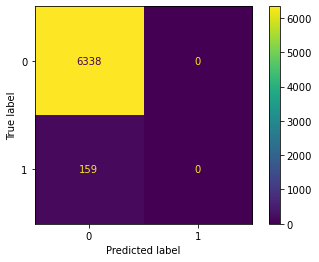

In [342]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
class_weights = compute_class_weight('balanced', np.unique(y_train_sub), y_train_sub)

# one hot encode (columns 15, 16, 17 only)
encode = ColumnTransformer(transformers=[('cat', OneHotEncoder(), [15,16,17])], remainder='passthrough' )

# define model
lg1 = LogisticRegression(random_state=13, class_weight=class_weights)

steps = [('encode', encode), ('model', lg1)]
pipeline = Pipeline(steps=steps)

# fit it
pipeline.fit(X_train_sub,y_train_sub)
# test
y_pred = pipeline.predict(X_val)
# performance
print(f'Accuracy Score: {accuracy_score(y_val,y_pred)}')
print(f'Area Under Curve: {roc_auc_score(y_val, y_pred)}')
print(f'Recall score: {recall_score(y_val,y_pred)}')
print(f'Recall score: {fbeta_score(y_val, y_pred, beta=2)}')
    
plot_confusion_matrix(pipeline, X_val, y_val, labels=None, sample_weight=None, normalize=None);

### Determine Optimal Tree Depth

Here we estimate optimal tree depth for a decision tree classifier. We will use this as the upper range for the tree depth hyperparameter in our grid search for the random forest classifier.

In [83]:
from sklearn.tree import DecisionTreeClassifier 

fb_scores = []
accuracy_scores = []
depth_range = list(range(1,50))

for i in depth_range:

    # one hot encode (columns 15, 16, 17 only)
    cat_col_indeces = []
    for i,col in enumerate(X_train.columns):
        if X_train[col].dtype = 'O':
            cat_col_indeces.append(i)
    
    encode = ColumnTransformer(transformers=[('cat', OneHotEncoder(), cat_col_indeces)], remainder='passthrough' )

    # instantiate model
    dt_model = DecisionTreeClassifier(max_depth=i, criterion='gini')

    # define pipeline
    steps = [('encode', encode), ('model', dt_model)]
    dt_pipeline = Pipeline(steps=steps)

    dt_pipeline.fit(X_train_sub, y_train_sub)
    
    y_pred = dt_pipeline.predict(X_val)
    
    f2 = fbeta_score(y_val, y_pred, beta=2)
    accuracy = accuracy_score(y_val, y_pred)
    
    fb_scores.append(f2)
    
    accuracy_scores.append(accuracy)

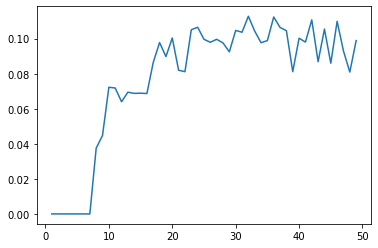

In [84]:
sns.lineplot(x=depth_range, y=fb_scores);

After 20, the f2 score oscillates but does not improve substantially

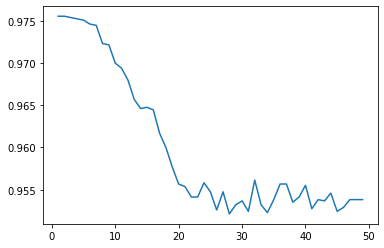

In [85]:
sns.lineplot(x=depth_range, y=accuracy_scores);

Accuracy goes down quickly with increased tree depth - suggesting that higher depths are resulting on overfitting

In [90]:
#outside pipeline, we calculate number of features (post dummy-encoding)
# which we use to estimate optimal value for n_estimators

# categoricals > dummies
cat_cols = ['WHR10', 'L2','L3']

X_train_sub_dummies = X_train_sub

for col in cat_cols:
    X_train_sub_dummies = pd.get_dummies(X_train_sub_dummies, columns=[col], drop_first=True, prefix=col)
    
X_train_sub_dummies.shape[1]

44

### Random Forest - No Oversampling
We are first trying a random forest model because a) the data is severely imbalanced and b) the classes are very mixed. Random forest models should perform well compared to models that cannot handle class imbalance well (such as KNN) or models that have trouble with very mixed classes (SVM). 

First we will try with no upsampling or downsampling, but we will weight the classes (class_weight='balanced subsample') so that the model pays extra attention to the minority class.

In [102]:
from sklearn.ensemble import RandomForestClassifier

# define grid search/random forest function that takes a param grid as input
def GridSearch_RandomForest(param_grid):
    
    #make f2 scorer
    f2_scorer = make_scorer(fbeta_score, beta=2)

    # one hot encode (columns 15, 16, 17 only)
    encode = ColumnTransformer(transformers=[('cat', OneHotEncoder(), [15,16,17])], remainder='passthrough')

    # instantiate model
    model = RandomForestClassifier(class_weight = 'balanced_subsample')

    # define pipeline
    steps = [('encode', encode), ('model', model)]
    pipeline = Pipeline(steps=steps)

    # define cross-validation
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1)

    # define grid search
    grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, n_jobs=-1, cv=cv, scoring=f2_scorer)

    # execute the grid search
    grid_result = grid.fit(X_train_sub, y_train_sub)

    # report the best configuration
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    
    return grid_result

`n_estimators` and `max_depth` are likely to influence model performance most because they control complexity. We will tune them first.
<br/> For `n_estimators` we have estimated 44 as the optimal number and select a few higher/lower values to test.
<br/> For `max_depth` we have estimated that 20 is the max (see decision tree above) and will test all values below that.

In [103]:
#grid search of most important hyperparameters
param_grid = {'model__n_estimators': [25, 44, 100, 200], # 44 is estimated optimal
        'model__max_depth' : list(range(1,20)), # 20 is estimated max for decision tree 
        }
        #'model__class_weight': [None, 'balanced', 'balanced_subsample']
        #'model__criterion' :['gini', 'entropy'],
        #'model__max_features': ['auto', 'sqrt', 'log2'],

RF_primary_parameters_GS = GridSearch_RandomForest(param_grid)

Best: 0.265421 using {'model__max_depth': 7, 'model__n_estimators': 44}


----- EVAL METRICS -----
Precision: 0.0872
Recall: 0.5723
F2: 0.2708


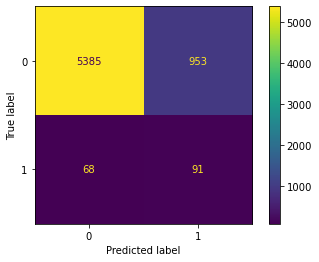

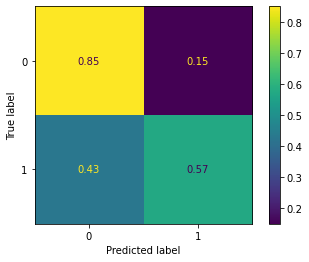

In [105]:
evaluate_model(RF_primary_parameters_GS.best_estimator_, X_train_sub, y_train_sub, X_val, y_val)

Model performance is a good start. As expected, 44 is optimal for N_estimators. 

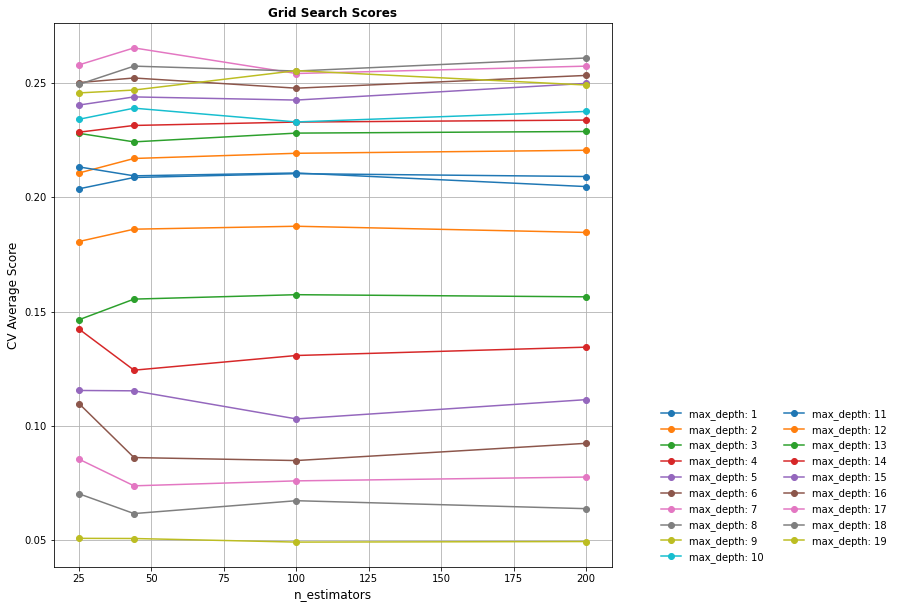

In [314]:
# plor grid search results
plot_grid_search(RF_primary_parameters_GS.cv_results_,[25, 44, 100, 200],list(range(1,20)),'n_estimators','max_depth')

Now we grid search the less critical parameters to see if performance can be improved.

In [344]:
#now we grid search the less critical parameters and critical parameters closer to optimal zone
param_grid = {'model__n_estimators': [40,44,50], # 44 is estimated optimal
        'model__max_depth' : list(range(1,8)), #7 and 8 were best results previously
        'model__class_weight': ['balanced', 'balanced_subsample'],
        'model__criterion' :['gini', 'entropy'],
        'model__max_features': ['auto', 'sqrt', 'log2']}

RF_secondary_parameters_GS = GridSearch_RandomForest(param_grid)

Best: 0.262029 using {'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__max_depth': 7, 'model__max_features': 'log2', 'model__n_estimators': 50}


----- EVAL METRICS -----
Precision: 0.0866
Recall: 0.5597
F2: 0.2674


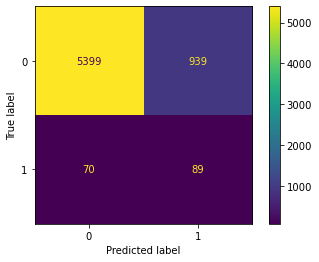

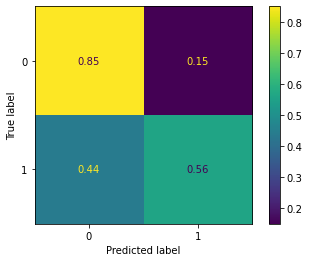

In [345]:
evaluate_model(RF_secondary_parameters_GS.best_estimator_, X_train_sub, y_train_sub, X_val, y_val)

Performance is better on validation set, but we must be careful not to overfit this particular validation set. The mean f2 score from cross validation is also slightly higher which gives us more confidence in our result.

### Random Forest - with under/oversampling

Now we will see if oversampling/undersampling can improve performance. Recall is currently only ~0.5 and this may be because the model doesn't have enough of the minority class to work with. We use a pipeline with SMOTE oversampling and random undersampling via Imbalanced Learn.

SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.
https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

We try a few different hyperparameter values for the sampling: ratios of over/under sampling as well as k for the SMOTE oversampling. This determines how many real members of the minority class are used to generate each synthesized record.

In [109]:
from imblearn.pipeline import Pipeline as Pipeline_imb
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score

In [114]:
# Random Search CV: random forest pipeline with SMOTE oversampling, undersampling

# parameter grid
param_grid = {'model__n_estimators': [40, 44, 50],
        'model__max_features': ['auto'],
        'model__max_depth' : list(range(6,10)),
        'model__criterion' :['gini'],
        'model__class_weight': ['balanced', 'balanced_subsample'],
       'under__sampling_strategy': [0.5, 0.8],
       'over__sampling_strategy': [0.1, 0.2],
       'over__k_neighbors': [2,5,10]}

# over sample minority class
cat_cols_mask = [True if col in cat_cols else False for col in X_train.columns]
over = SMOTENC(categorical_features=cat_cols_mask)

# under sample majority class
under = RandomUnderSampler()

# one hot encode (columns 15, 16, 17 only)
encode = ColumnTransformer(transformers=[('cat', OneHotEncoder(), [15,16,17])], remainder='passthrough' )

# instantiate model
model = RandomForestClassifier()

# define pipeline
steps = [('over', over), ('under', under), ('encode', encode), ('model', model)]
pipeline = Pipeline_imb(steps=steps)

# define cross-validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1)

# define grid search multi-metric scoring
scoring = {'Recall': make_scorer(recall_score), 'fbeta': make_scorer(fbeta_score, beta=2)}

# define grid search
grid = GridSearchCV(estimator=pipeline, param_grid=param_grid,
                          n_jobs=-1, cv=cv, scoring=scoring, refit='fbeta', return_train_score=False)

# execute the grid search
grid_result = grid.fit(X_train_sub, y_train_sub)

# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.242814 using {'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__max_depth': 9, 'model__max_features': 'auto', 'model__n_estimators': 44, 'over__k_neighbors': 2, 'over__sampling_strategy': 0.1, 'under__sampling_strategy': 0.5}


----- EVAL METRICS -----
Precision: 0.0796
Recall: 0.5786
F2: 0.2567


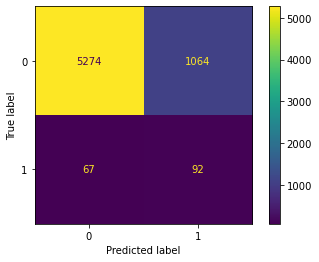

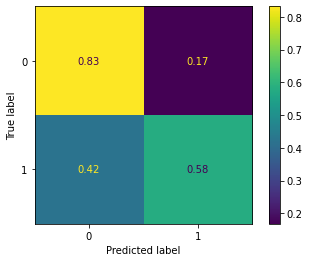

In [115]:
evaluate_model(grid_result.best_estimator_, X_train_sub, y_train_sub, X_val, y_val)

In [120]:
random_forest_SMOTE_results = pd.DataFrame(grid_result.cv_results_)

In [125]:
#compare results of different hyperparameter combinations
random_forest_SMOTE_results[['mean_test_fbeta','mean_test_Recall', 'param_model__max_depth',
                            'param_model__n_estimators','param_over__k_neighbors']].sort_values('mean_test_fbeta', ascending=False).head(20)

,mean_test_fbeta,mean_test_Recall,param_model__max_depth,param_model__n_estimators,param_over__k_neighbors
264,0.242814,0.516443,9,44,2
108,0.242055,0.508457,9,40,2
132,0.241887,0.513269,9,50,2
88,0.240817,0.554291,8,44,5
133,0.240459,0.547966,9,50,2
277,0.239792,0.552703,9,50,2
120,0.239020,0.499231,9,44,2
260,0.237887,0.495908,9,40,10
92,0.237749,0.535293,8,44,10
257,0.237317,0.544841,9,40,5


Over/under sampling results in increased recall but at the expense of precision/F2. This means that while more large wildfires are being correctly identified, more small wildfires are also being misclassified.

If this model is to provide value to wildland fire efforts we don't want it to incorrectly classify too many small fires as large. 

### XGBoost - No Sampling

Now we will try using the Extreme Gradient Boosting algorithm to see if it offers better performance than the standard random forest model. First we'll try with no over/undersampling.

Learning rate, subsample and min child weight = most important hyperparameters
https://blog.dataiku.com/narrowing-the-search-which-hyperparameters-really-matter

In [187]:
# determine ratio of positive to negeative classes in order to estimate optimal value for scale positive weight
from collections import Counter
counter = Counter(y_train)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 39.909


In [316]:
from xgboost import XGBClassifier

# parameter grid - these ranges were refined throgh a few iterations that are not shown here
param_grid = {'model__max_depth':[2,3,4,5,6,7],
              'model__learning_rate':np.arange(0.2, 1.0, 0.1),
              'model__colsample_bytree': np.arange(0.5, 1.0, 0.1),
              'model__subsample':np.arange(0.5, 1.0, 0.1),
              'model__min_child_weight':np.arange(0.1, 2, 0.1),
              'model__scale_pos_weight': np.arange(30,60,5)}

# one hot encode (columns 15, 16, 17 only)
encode = ColumnTransformer(transformers=[('cat', OneHotEncoder(), [15,16,17])], remainder='passthrough' )

# instantiate model
model = XGBClassifier(verbosity = 0)

# define pipeline
steps = [('encode', encode), ('model', model)]
pipeline = Pipeline_imb(steps=steps)

# define cross-validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1)

# define grid search multi-metric scoring
scoring = {'Recall': make_scorer(recall_score), 'fbeta': make_scorer(fbeta_score, beta=2)}

# define grid search
grid = RandomizedSearchCV(estimator=pipeline, n_iter = 100, param_distributions=param_grid,
                          n_jobs=-1, cv=cv, scoring=scoring, refit='fbeta', return_train_score=False)

# execute the grid search
grid_result_xgb = grid.fit(X_train_sub, y_train_sub)

# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.248066 using {'under__sampling_strategy': 0.8, 'over__sampling_strategy': 0.1, 'over__k_neighbors': 10, 'model__subsample': 0.7, 'model__scale_pos_weight': 2, 'model__min_child_weight': 0.9, 'model__max_depth': 4, 'model__learning_rate': 0.3, 'model__colsample_bytree': 0.8999999999999999}


In [348]:
print("Best: %f using %s" % (grid_result_xgb.best_score_, grid_result_xgb.best_params_))

Best: 0.265818 using {'model__subsample': 0.7999999999999999, 'model__scale_pos_weight': 30, 'model__min_child_weight': 1.7000000000000002, 'model__max_depth': 4, 'model__learning_rate': 0.2, 'model__colsample_bytree': 0.5}


In [359]:
def get_cv_scores(model):

    fbeta = round(model.cv_results_['mean_test_fbeta'][model.best_index_],4)
    recall = round(model.cv_results_['mean_test_Recall'][model.best_index_],4)
    
    print(f'F2: {fbeta}')
    print(f'Recall: {recall}')

In [360]:
get_cv_scores(grid_result_xgb)

F2: 0.2658
Recall: 0.4266


----- EVAL METRICS -----
Precision: 0.1108
Recall: 0.522
F2: 0.2996


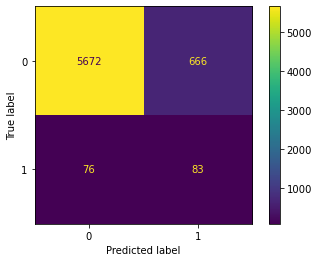

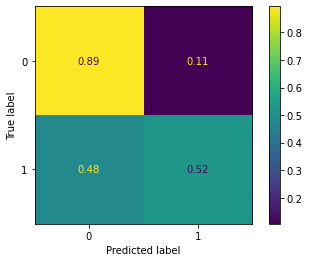

In [319]:
evaluate_model(grid_result_xgb.best_estimator_, X_train_sub, y_train_sub, X_val, y_val)

In [162]:
xgboost_results = pd.DataFrame(grid_result.cv_results_)

In [165]:
xgboost_results[['mean_test_fbeta',
                 'mean_test_Recall',
                 'param_model__subsample',
                 'param_model__scale_pos_weight',
                 'param_model__max_depth',
                 'param_model__learning_rate',
                 'param_model__colsample_bytree',
                 'param_model__subsample',
                 'param_model__min_child_weight'
                ]].sort_values('mean_test_fbeta', ascending=False).head(20)

,mean_test_fbeta,mean_test_Recall,param_model__subsample,param_model__scale_pos_weight,param_model__max_depth,param_model__learning_rate,param_model__colsample_bytree,param_model__subsample,param_model__min_child_weight
29,0.264906,0.456523,0.6,40,4,0.2,0.9,0.6,0.5
17,0.264668,0.414261,0.5,30,4,0.2,0.8,0.5,1.9
65,0.260379,0.585615,0.7,40,3,0.2,0.9,0.7,0.9
43,0.258205,0.456572,0.9,40,4,0.2,0.8,0.9,0.1
79,0.256943,0.547941,0.7,30,2,0.4,0.8,0.7,0.6
26,0.254530,0.396974,0.8,30,4,0.2,0.7,0.8,1.4
97,0.254056,0.525942,0.6,60,4,0.2,0.7,0.6,0.7
67,0.252169,0.511806,0.6,40,3,0.3,0.9,0.6,1.1
86,0.251968,0.494469,0.8,50,4,0.2,0.6,0.8,1.4
10,0.250601,0.525843,0.7,40,3,0.3,0.5,0.7,1.2


XGBoost is performing close, but slightly worse than the random forest classifier.

### XGBoost - SMOTE Oversampling

Now we try XGBoost with under/oversampling. Perhaps the poor performance is due to class imbalance. First we need to think about how changing the class balance will influence the upper/lower bounds of our scale_pos_weight hyperparameter. Because the class imbalance will be less, the scale_pos_weight should be greatly reduced and the range in the grid search should be adjusted accordingly. 

In [148]:
# determine ratio of positive to negative classes in order to estimate scale positive weight
over = SMOTENC(categorical_features=cat_cols_mask, sampling_strategy=0.1)
oversampled_x, oversampled_y = over.fit_resample(X_train_sub, y_train_sub)
under = RandomUnderSampler(sampling_strategy=0.2)

undersampled_x, undersampled_y = under.fit_resample(oversampled_x, oversampled_y)

from collections import Counter
counter = Counter(undersampled_y)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 5.000


In [351]:
from xgboost import XGBClassifier

param_grid = {'model__max_depth':[2,3,4],
              'model__learning_rate':[0.2, 0.3, 0.4],
              'model__colsample_bytree': np.arange(0.5, 1.0, 0.1),
              'model__subsample':np.arange(0.5, 1.0, 0.1),
              'model__min_child_weight':np.arange(0.1, 2, 0.1),
              'model__scale_pos_weight': [1, 2, 3, 5, 7],
             'under__sampling_strategy': [0.2, 0.5, 0.8],
              'over__sampling_strategy': [0.1, 0.2, 0.3],
              'over__k_neighbors': [2,5,10]}

# over sample minority class
cat_cols_mask = [True if col in cat_cols else False for col in X_train.columns]
over = SMOTENC(categorical_features=cat_cols_mask)

# under sample majority class
under = RandomUnderSampler()

# one hot encode (columns 15, 16, 17 only)
encode = ColumnTransformer(transformers=[('cat', OneHotEncoder(), [15,16,17])], remainder='passthrough' )

# instantiate model
model = XGBClassifier()

# define pipeline
steps = [('over',over), ('under', under), ('encode', encode), ('model', model)]
pipeline = Pipeline_imb(steps=steps)

# define cross-validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1)

# define grid search multi-metric scoring
scoring = {'Recall': make_scorer(recall_score), 'fbeta': make_scorer(fbeta_score, beta=2)}

# define grid search
grid = RandomizedSearchCV(estimator=pipeline, n_iter = 100, param_distributions=param_grid,
                          n_jobs=-1, cv=cv, scoring=scoring, refit='fbeta', return_train_score=False)

# execute the grid search
grid_result = grid.fit(X_train_sub, y_train_sub)

# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.243141 using {'under__sampling_strategy': 0.5, 'over__sampling_strategy': 0.2, 'over__k_neighbors': 5, 'model__subsample': 0.6, 'model__scale_pos_weight': 5, 'model__min_child_weight': 0.6, 'model__max_depth': 4, 'model__learning_rate': 0.2, 'model__colsample_bytree': 0.7}


[19:19:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1631904775127/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
----- EVAL METRICS -----
Precision: 0.0911
Recall: 0.5094
F2: 0.2656


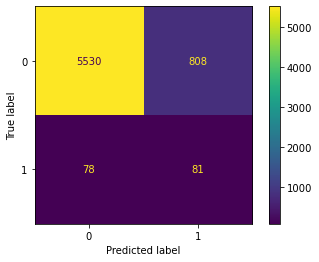

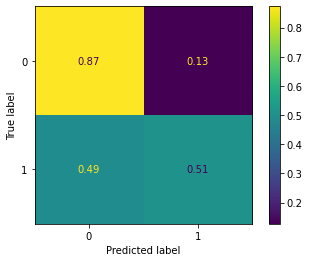

In [167]:
evaluate_model(grid_result.best_estimator_, X_train_sub, y_train_sub, X_val, y_val)

Performing okay - looks like its catching a decent amount of large without too many small

XGBoost allows us to see "Feature Importance", the relative degree to which each feature is contributing to the model's decision.

In [179]:
#create sorted dataframe of feature importance
from xgboost import plot_importance
best_model = grid_result.best_estimator_.fit(X_train, y_train)
feat_importance = best_model.named_steps['model'].feature_importances_
col_names = best_model.named_steps['encode'].get_feature_names()
pd.DataFrame({'col_name':col_names, 'Importance':feat_importance}).sort_values('Importance', ascending=False)

,col_name,Importance
0,cat__x0_Agriculture,0.206017
7,cat__x0_Urban,0.087940
4,cat__x0_Hardwood,0.045388
39,usda_fi2,0.042286
41,usda_fi4,0.037265
36,fm100,0.032803
18,cat__x2_Central_CA_Valley,0.030652
26,cat__x2_Sierra_Nevada,0.029675
16,cat__x2_Central_Basin_and_Range,0.027487
5,cat__x0_Herbaceous,0.026633


In [ ]:
#plot feature importance
fig, ax = plt.subplots(figsize=(5,10))
sns.barplot(ax=ax, data=lgb_importances, x='Importance', y="col_name")
ax.set_title('Feature Importance for LightGBM Model')
ax.set_ylabel('Feature Name')
ax.set_xlabel('Importance');

Interestingly, the categorical environment fields are contributing the most to the model. Perhaps this is because wildfires located in urban/agricultural areas tend to be closer to roads and are therefore more easily put out before they grow to be too large. Let's compare vs cross tabulation:

In [260]:
# plot bar chot of cross tabulation between fire size and another category
wfs_train = pd.concat([X_train,y_train], axis=1)
def plot_firesize_comparison(df,column,category):
    flag = df.apply(lambda r: 1 if r[column] == category else 0, axis=1)
    pd.crosstab(df['FIRE_SIZE_CLASS'],flag,normalize='index').plot.bar(stacked=True)
    plt.ylabel('Proportion of Fires')
    plt.xlabel('Fire Size Class')
    plt.legend([f'Non-{category}', category],loc='right')
    plt.title(f'Fire Size vs. {category}')

    plt.show()

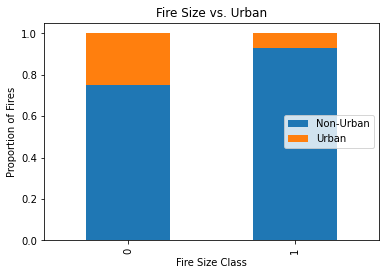

In [261]:
plot_firesize_comparison(wfs_train,'WHR10','Urban')

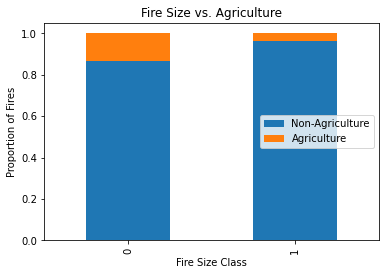

In [262]:
plot_firesize_comparison(wfs_train,'WHR10','Agriculture')

As expected, the charts show that wildfires are less likley to be large if they are in Urban or Agricultural areas. 

### Light GBM
XGBoost is not working as well as anticipated, so we try another popular gradient boosting algorithm.

First, with class weighting but no over/undersampling.

In [356]:
%%time
from lightgbm import LGBMClassifier

# parameter grid - these ranges were refined throgh a few iterations that are not shown here
param_grid = {'model__max_depth':range(3,12),
              'model__num_leaves': np.arange(20, 3000,20),
             'model__n_estimators': np.arange(50,1000,50),
             'model__learning_rate': np.arange(0.01,0.3,0.2),
             'model__lambda_l1':np.arange(1,100,10),
             'model__min_gain_to_split':np.arange(0,15),
             'model__bagging_fraction': np.arange(0.2,0.95, 0.1)}

# one hot encode (columns 15, 16, 17 only)
encode = ColumnTransformer(transformers=[('cat', OneHotEncoder(), [15,16,17])], remainder='passthrough' )

# instantiate model
model = LGBMClassifier(is_unbalance=True)

# define pipeline
steps = [('encode', encode), ('model', model)]
pipeline = Pipeline_imb(steps=steps)

# define cross-validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1)

# define grid search multi-metric scoring
scoring = {'Recall': make_scorer(recall_score), 'fbeta': make_scorer(fbeta_score, beta=2)}

# define grid search
grid = RandomizedSearchCV(estimator=pipeline, n_iter = 100, param_distributions=param_grid,
                          n_jobs=-1, cv=cv, scoring=scoring, refit='fbeta', return_train_score=False)

# execute the grid search
grid_result_lgb = grid.fit(X_train_sub, y_train_sub)

# report the best configuration
print("Best: %f using %s" % (grid_result_lgb.best_score_, grid_result_lgb.best_params_))

[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] lambda_l1 is set=81, reg_alpha=0.0 will be ignored. Current value: lambda_l1=81
Best: 0.279710 using {'model__num_leaves': 220, 'model__n_estimators': 950, 'model__min_gain_to_split': 0, 'model__max_depth': 7, 'model__learning_rate': 0.01, 'model__lambda_l1': 81, 'model__bagging_fraction': 0.6000000000000001}
CPU times: user 27.7 s, sys: 3.06 s, total: 30.8 s
Wall time: 3min 18s


In [361]:
get_cv_scores(grid_result_lgb)

F2: 0.2797
Recall: 0.5087


----- EVAL METRICS -----
Precision: 0.1122
Recall: 0.5975
F2: 0.3203


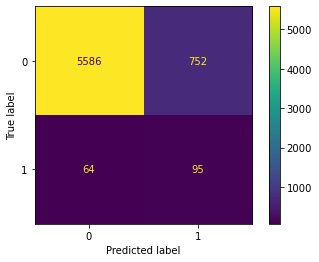

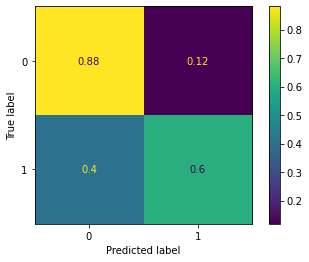

In [357]:
evaluate_model(grid_result_lgb.best_estimator_, X_train_sub, y_train_sub, X_val, y_val)

We see significant improvement over both random forest and XGBoost!

In [375]:
#create sorted dataframe of feature importance
from lightgbm import plot_importance
best_model = grid_result_lgb.best_estimator_.fit(X_train, y_train)
feat_importance = best_model.named_steps['model'].feature_importances_
col_names = best_model.named_steps['encode'].get_feature_names()
lgb_importances = pd.DataFrame({'col_name':col_names, 'Importance':feat_importance}).sort_values('Importance', ascending=False)

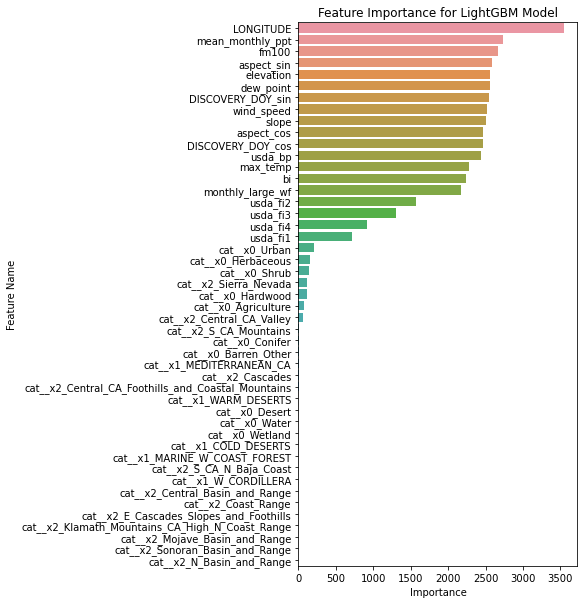

In [384]:
#plot feature importance
fig, ax = plt.subplots(figsize=(5,10))
sns.barplot(ax=ax, data=lgb_importances, x='Importance', y="col_name")
ax.set_title('Feature Importance for LightGBM Model')
ax.set_ylabel('Feature Name')
ax.set_xlabel('Importance');

The feature importance chart above looks very different than the  feature importance table for the XGBoost model. While for XGBoost dummy/categorical columns for Agriculture and Urban were most important, here we see that the numeric weather variables from Google Earth Engine are much more prominent.

Perhaps this is why performance has been greatly improved.

### LightGBM with Over/UnderSampling

Now we try LightGBM with SMOTE oversampling/random undersampling

In [362]:
%%time
from lightgbm import LGBMClassifier

# parameter grid - these ranges were refined throgh a few iterations that are not shown here
param_grid = {'model__max_depth':range(3,12),
              'model__num_leaves': np.arange(20, 3000,20),
             'model__n_estimators': np.arange(50,1000,50),
             'model__learning_rate': np.arange(0.01,0.3,0.2),
             'model__lambda_l1':np.arange(1,100,10),
             'model__min_gain_to_split':np.arange(0,15),
             'model__bagging_fraction': np.arange(0.2,0.95, 0.1),
             'under__sampling_strategy': np.arange(0.2,0.98, 0.2),
             'over__sampling_strategy': [0.1, 0.2, 0.3],
             'over__k_neighbors': [2,5,10]}

# over sample minority class
cat_cols_mask = [True if col in cat_cols else False for col in X_train.columns]
over = SMOTENC(categorical_features=cat_cols_mask)

# under sample majority class
under = RandomUnderSampler()

# one hot encode (columns 15, 16, 17 only)
encode = ColumnTransformer(transformers=[('cat', OneHotEncoder(), [15,16,17])], remainder='passthrough' )

# instantiate model
model = LGBMClassifier(is_unbalance=True)

# define pipeline
steps = [('over',over), ('under', under), ('encode', encode), ('model', model)]
pipeline = Pipeline_imb(steps=steps)

# define cross-validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1)

# define grid search multi-metric scoring
scoring = {'Recall': make_scorer(recall_score), 'fbeta': make_scorer(fbeta_score, beta=2)}

# define grid search
grid = RandomizedSearchCV(estimator=pipeline, n_iter = 100, param_distributions=param_grid,
                          n_jobs=-1, cv=cv, scoring=scoring, refit='fbeta', return_train_score=False)

# execute the grid search
grid_result_lgb_sampling = grid.fit(X_train_sub, y_train_sub)

# report the best configuration
print("Best: %f using %s" % (grid_result_lgb_sampling.best_score_, grid_result_lgb.best_params_))

[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=12, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12
[LightGBM] [Warning] lambda_l1 is set=11, reg_alpha=0.0 will be ignored. Current value: lambda_l1=11
Best: 0.239136 using {'model__num_leaves': 220, 'model__n_estimators': 950, 'model__min_gain_to_split': 0, 'model__max_depth': 7, 'model__learning_rate': 0.01, 'model__lambda_l1': 81, 'model__bagging_fraction': 0.6000000000000001}
CPU times: user 9.86 s, sys: 1.26 s, total: 11.1 s
Wall time: 4min 16s


In [363]:
get_cv_scores(grid_result_lgb_sampling)

F2: 0.2391
Recall: 0.414


[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=12, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12
[LightGBM] [Warning] lambda_l1 is set=11, reg_alpha=0.0 will be ignored. Current value: lambda_l1=11
----- EVAL METRICS -----
Precision: 0.0984
Recall: 0.4906
F2: 0.2729


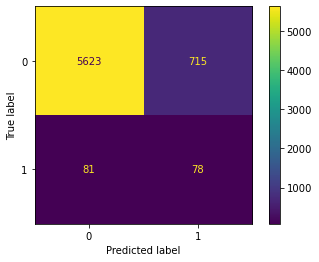

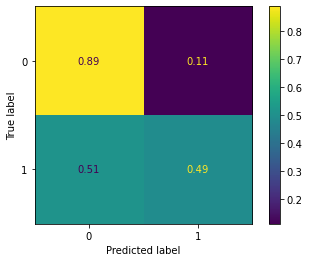

In [365]:
evaluate_model(grid_result_lgb_sampling.best_estimator_, X_train_sub, y_train_sub, X_val, y_val)

Performance is not as good as the LightGBM model without overundersampling.

For all three algorithms, the addition of under/oversampling has negatively impacted performance (although for some the recall was improved). This is counter to most information available online which suggests that oversampling improves model performance for imbalanced classification. Perhaps in this instance the SMOTE method is creating records that wouldn't actually exist in reality and therefore a model trained on these is forming worse when encountering unseen data.

### Hyperparameter Tuning of LightGBM with Optuna

Of all the algorithms/pipelines we have tried, LightGBM (class weighted, no over/undersampling) is performing the best. Now we'll try to optimize the hyperparameters as much as possible using Optuna (rather than RandomSearchCV).

Credit: https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5

In [469]:
#dummy encode categorical variables for train and validation set (since we will not use an Sklearn pipeline here)
# train (subset) and validation sets
X_train_sub_dummies = pd.get_dummies(X_train_sub, columns=['WHR10','L2','L3'], drop_first=True)
X_val_dummies = pd.get_dummies(X_val, columns=['WHR10','L2','L3'], drop_first=True)

# full train and test sets (for final model)
X_train_dummies = pd.get_dummies(X_train, columns=['WHR10','L2','L3'], drop_first=True)
X_test_dummies = pd.get_dummies(X_test, columns=['WHR10','L2','L3'], drop_first=True)

In [470]:
# modified evaluate model function to handle optuna outputs
def evaluate_model_lgb(best_params, X_t, y_t, X_v, y_v):
        
    # fit model to training data
    lgb = LGBMClassifier(is_unbalance=True, **best_params)
    lgb.fit(X_t,y_t)

    # predict on validation set
    y_pred = lgb.predict(X_v)

    # calculate other evaluation metrics
    precision = round(precision_score(y_v, y_pred),4)
    recall = round(recall_score(y_v, y_pred),4)
    f2 = round(fbeta_score(y_v, y_pred, beta=2),4)
    
    #plot confusion matrix (on validation data)
    plot_confusion_matrix(lgb, X_v, y_v, labels=None, sample_weight=None, normalize=None);
    
    #plot confusion matrix (on validation data)
    plot_confusion_matrix(lgb, X_v, y_v, labels=None, sample_weight=None, normalize='true');

    # print evaluation metrics
    print('----- EVAL METRICS -----')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F2: {f2}')

In [407]:
import optuna

# define scoring
f2_scorer = make_scorer(fbeta_score, beta=2)

# define objective for optuna study
def objective(trial):
    
    # parameter grid with ranges
    param_grid = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 1000, step=50),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.2, 0.95, step=0.1),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.2, 0.95, step=0.1),}
    
    #instantiate model
    lgb = LGBMClassifier(is_unbalance=True, **param_grid)
    
    #cross validation with 10 folds
    return cross_val_score(lgb, X_train_sub_dummies, y_train_sub, n_jobs=-1, cv=10,scoring=f2_scorer).mean()

In [408]:
%%time
# optuna hyperparemter optimization study with 200 trials
study = optuna.create_study(direction='maximize', study_name="LGBM Classifier 1")
study.optimize(objective, n_trials=200)

[I 2021-10-03 22:22:29,642] A new study created in memory with name: LGBM Classifier 1
[I 2021-10-03 22:22:31,775] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 150, 'learning_rate': 0.12179793316905364, 'num_leaves': 480, 'max_depth': 4, 'min_data_in_leaf': 8700, 'lambda_l1': 35, 'lambda_l2': 85, 'min_gain_to_split': 12.131173105344008, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 0 with value: 0.0.
[I 2021-10-03 22:22:34,812] Trial 1 finished with value: 0.26314679432742116 and parameters: {'n_estimators': 800, 'learning_rate': 0.03286346671989637, 'num_leaves': 2080, 'max_depth': 6, 'min_data_in_leaf': 1500, 'lambda_l1': 65, 'lambda_l2': 55, 'min_gain_to_split': 8.75098044779839, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 1 with value: 0.26314679432742116.
[I 2021-10-03 22:22:35,799] Trial 2 finished with value: 0.24090261229946588 and parameters: {'n_estimators': 150, 'learning_rate'

[I 2021-10-03 22:23:13,399] Trial 20 finished with value: 0.2706957560349543 and parameters: {'n_estimators': 800, 'learning_rate': 0.04085200150923672, 'num_leaves': 880, 'max_depth': 5, 'min_data_in_leaf': 1600, 'lambda_l1': 40, 'lambda_l2': 40, 'min_gain_to_split': 2.311268623451527, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 20 with value: 0.2706957560349543.
[I 2021-10-03 22:23:16,769] Trial 21 finished with value: 0.2619489122888032 and parameters: {'n_estimators': 850, 'learning_rate': 0.04325488004379828, 'num_leaves': 760, 'max_depth': 5, 'min_data_in_leaf': 1700, 'lambda_l1': 40, 'lambda_l2': 20, 'min_gain_to_split': 2.1343977993097103, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 20 with value: 0.2706957560349543.
[I 2021-10-03 22:23:19,929] Trial 22 finished with value: 0.2313341182509426 and parameters: {'n_estimators': 900, 'learning_rate': 0.03310061402821731, 'n

[I 2021-10-03 22:24:18,291] Trial 40 finished with value: 0.20135411759332927 and parameters: {'n_estimators': 800, 'learning_rate': 0.296645506396885, 'num_leaves': 600, 'max_depth': 8, 'min_data_in_leaf': 600, 'lambda_l1': 5, 'lambda_l2': 70, 'min_gain_to_split': 3.011055130693684, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 32 with value: 0.2901348417320281.
[I 2021-10-03 22:24:21,285] Trial 41 finished with value: 0.271344204071844 and parameters: {'n_estimators': 450, 'learning_rate': 0.055773975420561644, 'num_leaves': 300, 'max_depth': 7, 'min_data_in_leaf': 600, 'lambda_l1': 5, 'lambda_l2': 85, 'min_gain_to_split': 3.952146241996046, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 32 with value: 0.2901348417320281.
[I 2021-10-03 22:24:25,454] Trial 42 finished with value: 0.27554933157216055 and parameters: {'n_estimators': 500, 'learning_rate': 0.07565706806120781, 'num_leaves': 600, 'ma

[I 2021-10-03 22:25:15,568] Trial 60 finished with value: 0.2656284582542738 and parameters: {'n_estimators': 600, 'learning_rate': 0.0651600384255167, 'num_leaves': 2360, 'max_depth': 4, 'min_data_in_leaf': 1500, 'lambda_l1': 20, 'lambda_l2': 70, 'min_gain_to_split': 0.7911384950633685, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 51 with value: 0.2901435886596625.
[I 2021-10-03 22:25:21,903] Trial 61 finished with value: 0.28393816948973916 and parameters: {'n_estimators': 800, 'learning_rate': 0.04438233261723153, 'num_leaves': 740, 'max_depth': 7, 'min_data_in_leaf': 400, 'lambda_l1': 0, 'lambda_l2': 60, 'min_gain_to_split': 1.641298363334778, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 51 with value: 0.2901435886596625.
[I 2021-10-03 22:25:26,932] Trial 62 finished with value: 0.26983078206530314 and parameters: {'n_estimators': 800, 'learning_rate': 0.027137363459382585, '

[I 2021-10-03 22:26:38,555] Trial 79 finished with value: 0.2708176854695276 and parameters: {'n_estimators': 950, 'learning_rate': 0.04332499118459215, 'num_leaves': 900, 'max_depth': 5, 'min_data_in_leaf': 1900, 'lambda_l1': 0, 'lambda_l2': 65, 'min_gain_to_split': 6.20665753232719, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 51 with value: 0.2901435886596625.
[I 2021-10-03 22:26:42,847] Trial 80 finished with value: 0.25672937528671 and parameters: {'n_estimators': 850, 'learning_rate': 0.01901171848782729, 'num_leaves': 2340, 'max_depth': 7, 'min_data_in_leaf': 1000, 'lambda_l1': 10, 'lambda_l2': 55, 'min_gain_to_split': 7.740294090016608, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 51 with value: 0.2901435886596625.
[I 2021-10-03 22:26:48,540] Trial 81 finished with value: 0.2791996358640925 and parameters: {'n_estimators': 1000, 'learning_rate': 0.03242574510249314, 'num_leaves': 600, '

[I 2021-10-03 22:27:45,875] Trial 99 finished with value: 0.0 and parameters: {'n_estimators': 400, 'learning_rate': 0.07212268544617281, 'num_leaves': 280, 'max_depth': 10, 'min_data_in_leaf': 7300, 'lambda_l1': 5, 'lambda_l2': 80, 'min_gain_to_split': 4.307353020632053, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 88 with value: 0.2943968036922397.
[I 2021-10-03 22:27:48,544] Trial 100 finished with value: 0.26683591488450425 and parameters: {'n_estimators': 450, 'learning_rate': 0.01605424257344798, 'num_leaves': 400, 'max_depth': 8, 'min_data_in_leaf': 700, 'lambda_l1': 10, 'lambda_l2': 65, 'min_gain_to_split': 7.540216632452266, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 88 with value: 0.2943968036922397.
[I 2021-10-03 22:27:50,692] Trial 101 finished with value: 0.2863975069840506 and parameters: {'n_estimators': 350, 'learning_rate': 0.0697384605031282, 'num_leaves': 200

[I 2021-10-03 22:28:31,224] Trial 119 finished with value: 0.2846976626880664 and parameters: {'n_estimators': 500, 'learning_rate': 0.06350132908562425, 'num_leaves': 500, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 15, 'lambda_l2': 85, 'min_gain_to_split': 3.4997158231872425, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 88 with value: 0.2943968036922397.
[I 2021-10-03 22:28:34,506] Trial 120 finished with value: 0.28171438302669116 and parameters: {'n_estimators': 550, 'learning_rate': 0.05347080667401532, 'num_leaves': 420, 'max_depth': 9, 'min_data_in_leaf': 900, 'lambda_l1': 15, 'lambda_l2': 90, 'min_gain_to_split': 3.1376732462073034, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 88 with value: 0.2943968036922397.
[I 2021-10-03 22:28:37,562] Trial 121 finished with value: 0.29259880930829785 and parameters: {'n_estimators': 450, 'learning_rate': 0.07171440358009466, 'num_leaves': 80, 'max_depth

[I 2021-10-03 22:29:21,391] Trial 139 finished with value: 0.3001387515424596 and parameters: {'n_estimators': 350, 'learning_rate': 0.04936331715803258, 'num_leaves': 260, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 5, 'lambda_l2': 100, 'min_gain_to_split': 4.650339765275678, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 139 with value: 0.3001387515424596.
[I 2021-10-03 22:29:23,220] Trial 140 finished with value: 0.275733516590115 and parameters: {'n_estimators': 300, 'learning_rate': 0.17827592292174982, 'num_leaves': 260, 'max_depth': 10, 'min_data_in_leaf': 800, 'lambda_l1': 5, 'lambda_l2': 100, 'min_gain_to_split': 4.799075008815973, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 139 with value: 0.3001387515424596.
[I 2021-10-03 22:29:25,750] Trial 141 finished with value: 0.2938559192273543 and parameters: {'n_estimators': 350, 'learning_rate': 0.04845464155561616, 'num_leaves': 360, 'max_depth

[I 2021-10-03 22:30:10,768] Trial 159 finished with value: 0.2888610863280195 and parameters: {'n_estimators': 800, 'learning_rate': 0.05145174143799119, 'num_leaves': 220, 'max_depth': 11, 'min_data_in_leaf': 800, 'lambda_l1': 10, 'lambda_l2': 100, 'min_gain_to_split': 4.899776581416473, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 139 with value: 0.3001387515424596.
[I 2021-10-03 22:30:13,655] Trial 160 finished with value: 0.2710509970564977 and parameters: {'n_estimators': 800, 'learning_rate': 0.07405941924288723, 'num_leaves': 460, 'max_depth': 10, 'min_data_in_leaf': 500, 'lambda_l1': 75, 'lambda_l2': 100, 'min_gain_to_split': 5.288263263192869, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 139 with value: 0.3001387515424596.
[I 2021-10-03 22:30:16,240] Trial 161 finished with value: 0.2878640131357197 and parameters: {'n_estimators': 350, 'learning_rate': 0.044845439144732144, 'num_leaves': 100, 'max_d

[I 2021-10-03 22:31:04,164] Trial 179 finished with value: 0.2885563352295402 and parameters: {'n_estimators': 850, 'learning_rate': 0.04439051264550981, 'num_leaves': 300, 'max_depth': 10, 'min_data_in_leaf': 900, 'lambda_l1': 15, 'lambda_l2': 90, 'min_gain_to_split': 4.902819338092058, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 139 with value: 0.3001387515424596.
[I 2021-10-03 22:31:08,210] Trial 180 finished with value: 0.27450757652769037 and parameters: {'n_estimators': 850, 'learning_rate': 0.03458522135250294, 'num_leaves': 460, 'max_depth': 10, 'min_data_in_leaf': 1300, 'lambda_l1': 10, 'lambda_l2': 90, 'min_gain_to_split': 3.912014663895727, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 139 with value: 0.3001387515424596.
[I 2021-10-03 22:31:12,486] Trial 181 finished with value: 0.2952440895634127 and parameters: {'n_estimators': 800, 'learning_rate': 0.048535923098850846, 'num_leaves': 360, 'max_d

[I 2021-10-03 22:32:31,572] Trial 199 finished with value: 0.2900464698313259 and parameters: {'n_estimators': 850, 'learning_rate': 0.03618093812221628, 'num_leaves': 580, 'max_depth': 10, 'min_data_in_leaf': 900, 'lambda_l1': 5, 'lambda_l2': 95, 'min_gain_to_split': 5.902969118860383, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 139 with value: 0.3001387515424596.


CPU times: user 10.7 s, sys: 1.82 s, total: 12.5 s
Wall time: 10min 1s


In [431]:
# get results/settings from best trial
trial_1_best = study.best_trial
print('F2: {}'.format(trial_1_best.value))
print("Best hyperparameters: {}".format(trial_1_best.params))
trial_1_best_params = study.best_params

F2: 0.3001387515424596
Best hyperparameters: {'n_estimators': 350, 'learning_rate': 0.04936331715803258, 'num_leaves': 260, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 5, 'lambda_l2': 100, 'min_gain_to_split': 4.650339765275678, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.7}


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.650339765275678, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.650339765275678
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
----- EVAL METRICS -----
Precision: 0.1252
Recall: 0.5597
F2: 0.3304


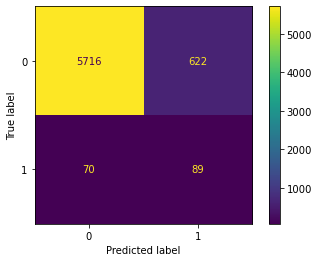

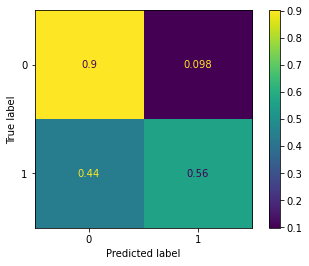

In [432]:
#evaulate model trained on best settings
evaluate_model_lgb(trial_1_best_params, X_train_sub_dummies, y_train_sub, X_val_dummies, y_val)

After hyperparameter tuning with optuna, the LightGBM model performs even better than before. This is the best performing model by far, so we will move forward with it. First, let's see the feature importances in the model:

In [476]:
lgbm = LGBMClassifier(is_unbalance=True, **trial_1_best_params)
grid_result_lgbm = lgbm.fit(X_train_dummies,y_train)

feat_importance = grid_result_lgbm.feature_importances_
col_names = X_train_dummies.columns
lgbm_importances = pd.DataFrame({'col_name':col_names, 'Importance':feat_importance}).sort_values('Importance', ascending=False)

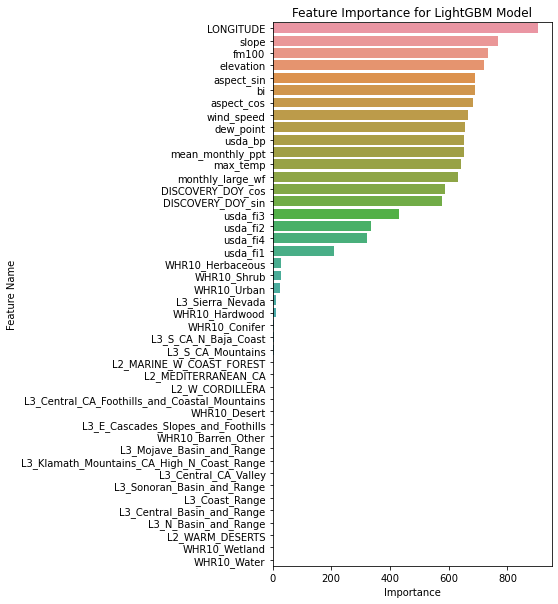

In [477]:
#plot feature importance
fig, ax = plt.subplots(figsize=(5,10))
sns.barplot(ax=ax, data=lgb_importances, x='Importance', y="col_name")
ax.set_title('Feature Importance for LightGBM Model')
ax.set_ylabel('Feature Name')
ax.set_xlabel('Importance');

Feature importances are similar to the first LightGBM model

# Final Model Training and Evaluation

Now that we have selected our best performing model (based on f2 scores from 10-fold cross validation) we will train it on our full training set and evaluate performance on the hold-out test set that has not previously been used.

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.650339765275678, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.650339765275678
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
----- EVAL METRICS -----
Precision: 0.0978
Recall: 0.4221
F2: 0.2538


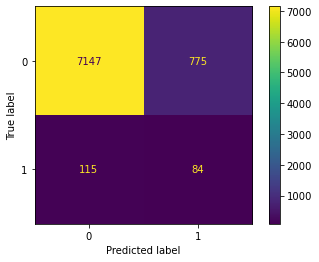

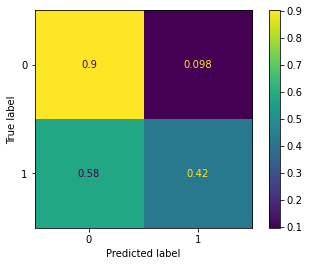

In [483]:
#evaulate model trained on best settings
evaluate_model_lgb(trial_1_best_params, X_train_dummies, y_train, X_test_dummies, y_test)

As is to be expected, the performance is worse on the test data, but still good enough to be valuable.